In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [2]:
# You don't have to understand how this function works, since it uses Python features from beyond Data 8.
def first_digit(num):
    return int(str(num)[0])

## Example: Benford's Law

"Benford's law, also called the Newcomb–Benford law, the law of anomalous numbers, or the first-digit law, is an observation about the frequency distribution of leading digits in many real-life sets of numerical data. The law states that in many naturally occurring collections of numbers, the leading digit is likely to be small.[1] In sets that obey the law, the number 1 appears as the leading significant digit about 30 % of the time, while 9 appears as the leading significant digit less than 5 % of the time. If the digits were distributed uniformly, they would each occur about 11.1 % of the time.[2] Benford's law also makes predictions about the distribution of second digits, third digits, digit combinations, and so on." - Wikipedia


TLDR:

- based on observations of numerical datasets
- specific categorical distribution for the leading digits of numbers.

In [3]:
first_digit(32)

3

In [4]:
first_digit(17719087)

1

In [5]:
digits = np.arange(1, 10)
benford_model = np.log10(1 + 1/digits)

### The distribution

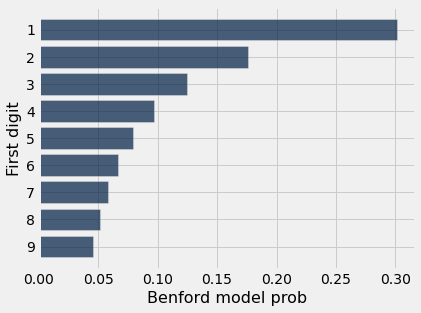

In [6]:
benford = Table().with_columns(
    'First digit', digits,
    'Benford model prob', benford_model)
benford.barh('First digit')

# Population Data

- each county
- it's population

In [7]:
# County populations from the census data
counties = Table.read_table('counties.csv')
counties = counties.where('SUMLEV', 50).select(5,6,9).relabeled(0,'State').relabeled(1,'County').relabeled(2,'Population')
counties.show(3)

State,County,Population
Alabama,Autauga County,54684
Alabama,Baldwin County,183216
Alabama,Barbour County,27336


In [8]:
first_digits = counties.apply(first_digit, 'Population')
counties = counties.with_column('First digit', first_digits)
counties.show(3)

State,County,Population,First digit
Alabama,Autauga County,54684,5
Alabama,Baldwin County,183216,1
Alabama,Barbour County,27336,2


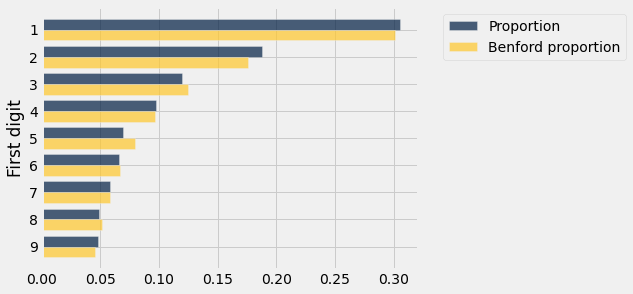

In [9]:
num_counties = counties.num_rows
by_digit = counties.group('First digit')
proportions = by_digit.column('count')/num_counties
by_digit = by_digit.with_columns(
    'Proportion', proportions,
    'Benford proportion', benford_model
)
by_digit.drop('count').barh('First digit')

Null hypothesis: each population for the county in the US is drawn from a categorical distribution specified by Benfords's law

Alternative hypothesis: each population for the county in the US is drawn from a categorical distribution that is different from the one specified by Benfords's law

Test statistic: TVD(benford_model, sample's categorical distribution)

Fill in the blank with "Bigger" or "Smaller":

Bigger values of the test statistic favor the alternative

In [10]:
observed_tvd = sum(abs(proportions - benford_model))/2
observed_tvd

0.01922756971800583

In [11]:
sample_proportions(num_counties, benford_model)

array([0.30776575, 0.19096117, 0.12030554, 0.08911521, 0.07352005,
       0.05856143, 0.06460853, 0.04678549, 0.04837683])

In [12]:
simulated_frequencies = sample_proportions(num_counties, benford_model)
tvd = sum(abs(simulated_frequencies - benford_model))/2
tvd

0.02213240998278329

In [13]:
def simulate_county_first_digits():
    simulated_frequencies = sample_proportions(num_counties, benford_model)
    tvd = sum(abs(simulated_frequencies - benford_model))/2
    return tvd

In [14]:
simulated_tvds = make_array()

for i in np.arange(10000):
    simulated_tvds = np.append(simulated_tvds, simulate_county_first_digits())

Observed TVD:  0.01922756971800583


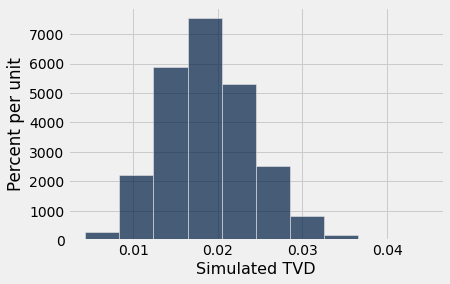

In [15]:
Table().with_column('Simulated TVD', simulated_tvds).hist(0)
print("Observed TVD: ", observed_tvd)

In [16]:
# p-value. 
# Since bigger values favor the alternative we check if our simulated_tvds is greater than or equal to observed_tvd
np.count_nonzero(simulated_tvds >= observed_tvd) / 10000

0.4474

Are the data consistent with the null hypothesis?

_Yes the data is consistent with the null hypothesis. Since p-value is 45% which is greater than 5%, we conclude that we failed to reject the null hypothesis._

- Questions
- Slides really quick


## Example: sleep survey

In [17]:
survey = Table.read_table('welcome_survey.csv').drop(0)
survey

timezone,extraversion,texting info,hours sleep,sleep style
EST - Eastern Standard Time,7,6,7,On your right side
PST - Pacific Standard Time,10,5,5,On your right side
PST - Pacific Standard Time,6,7,8,On your right side
PST - Pacific Standard Time,6,2,7,On your back
PST - Pacific Standard Time,8,5,7,On your left side
PST - Pacific Standard Time,7,1,7,On your left side
PST - Pacific Standard Time,3,5,7,On your right side
PST - Pacific Standard Time,5,0,7,On your back
PST - Pacific Standard Time,3,3,6,On your right side
PST - Pacific Standard Time,7,7,7,On your right side


In [18]:
def simplify(sleep_position):
    if sleep_position == 'On your left side' or sleep_position == 'On your right side':
        return 'side'
    else:
        return 'back or stomach'
    
survey = survey.with_column(
    'position',
    survey.apply(simplify, 'sleep style')
).select('position', 'hours sleep')

survey

position,hours sleep
side,7
side,5
side,8
back or stomach,7
side,7
side,7
side,7
back or stomach,7
side,6
side,7


In [19]:
survey.group('position', np.average)

position,hours sleep average
back or stomach,7.17045
side,7.15337


Null hypothesis: the population distribution of hours of sleep for people who sleep on their back or stomach is the same as the population distribution of hours of sleep for people who sleep on their side on average

Alternative hypothesis: the population distribution of hours of sleep for people who sleep on their back or stomach is the higher on average than the population distribution of hours of sleep for people who sleep on their side

Test statistic: avg hours of sleep stomach/back - avg hours of sleep side

Fill in the blank with "Bigger" or "Smaller":

Bigger values of the test statistic favor the alternative

In [20]:
def compute_test_statistic(tbl):
    grouped = tbl.group('position', np.average)
    avgs = grouped.column('hours sleep average')
    return avgs.item(1) - avgs.item(0)

In [21]:
obs_test_stat = compute_test_statistic(survey)
obs_test_stat

-0.017080312325711944

In [22]:
random_labels = survey.sample(with_replacement=False).column('position')

In [23]:
def simulate_under_null():
    random_labels = survey.sample(with_replacement=False).column('position')
    relabeled_tbl = survey.with_column('position', random_labels)
    return compute_test_statistic(relabeled_tbl)

In [24]:
simulated_diffs = make_array()
for i in np.arange(500):
    null_stat = simulate_under_null()
    simulated_diffs = np.append(simulated_diffs, null_stat)

Observed Difference:  -0.017080312325711944


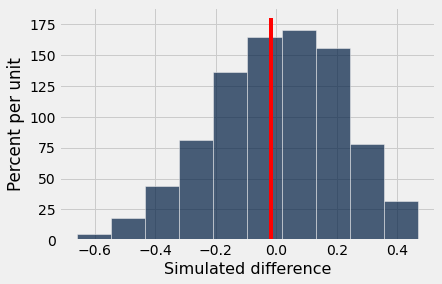

In [25]:
Table().with_column('Simulated difference', simulated_diffs).hist(0)

# Ignore this code
plots.plot([obs_test_stat, obs_test_stat], [0, 1.8], c="r")
print("Observed Difference: ", obs_test_stat)

In [26]:
np.mean(simulated_diffs <= obs_test_stat)

0.448

Are the data consistent with the null hypothesis?

_The data is consistent with the null hypothesis. Since p value is 41%, we fail to reject the null hypothesis._